# <center>How to Conquer the World</center>

_ _
   
## _<center>Genetic algorithms and the game of Risk</center>_

_ _

### <center> Rogier van der Geer </center>

_ _

#### <center> Data Charmer @ GoDataDriven</center> 

## _<center>Risk Analysis</center>_

In [1]:
%matplotlib inline

## Overview

- The game of Risk

- Risk in Python

- Genetic Algorithms

- Using a genetic algorithm to play Risk

# Risk

Invented in 1957 as _The Conquest of the World,_     
since 1959: _Risk: The Game of Global Domination._
    
<br>
### According to the publishers:

- _Players:_ 2-6 
- _Playing time:_ 1-8 hours

### The game board

![risk.png](risk.png)

### Assignment of territories

![risk.png](starting.png)

### Placing armies

![risk.png](initial.png)

### A turn consists of three stages:

- __Reinforcement__
- __Combat__
- __Fortification__

- __Reinforcement:__ the player places additional armies:
  - one army per three territories,
  - bonus armies for owning a full continent,
  - additional bonus for a set of _reinforcement cards_.

- __Combat:__ the player may attack neighboring territories:
  - the battle is decided using dice,
  - the attacker has a good chance to win if he has more armies,
  - if the attacker conquers a territory he gets a reinforcement card,
  - the player may attack indefinitely.

- __Fortification:__ the player may move armies:
  - may make only _one_ fortification move,
  - from one territory to a neighboring territory,
  - with as many armies as he likes.

### Missions

Each player is assigned a mission. By completing the mission the player wins the game.    

Missions are, for example:
- Conquer africa and north america
- Destroy the yellow player
- Conquer at least 24 territories
- ...



# Risk in Python

We built a framework that handles all aspects of the Risk game. It consists of five classes:

- `Board`, which handles the armies on the game board,
- `Cards`, which handles the reinforcement cards of a player,
- `Mission`, which describes the mission of a player,
- `Player`, which makes decisions on how to play, and
- `Game`, which handles all other aspects of the game.

### The Board

When initialized, the board randomly distributes the territories amongst the players.

In [2]:
import random
random.seed(42)

In [3]:
from board import Board
b = Board.create(n_players=4)

We can get a graphical representation of the board using `plot_board()`:

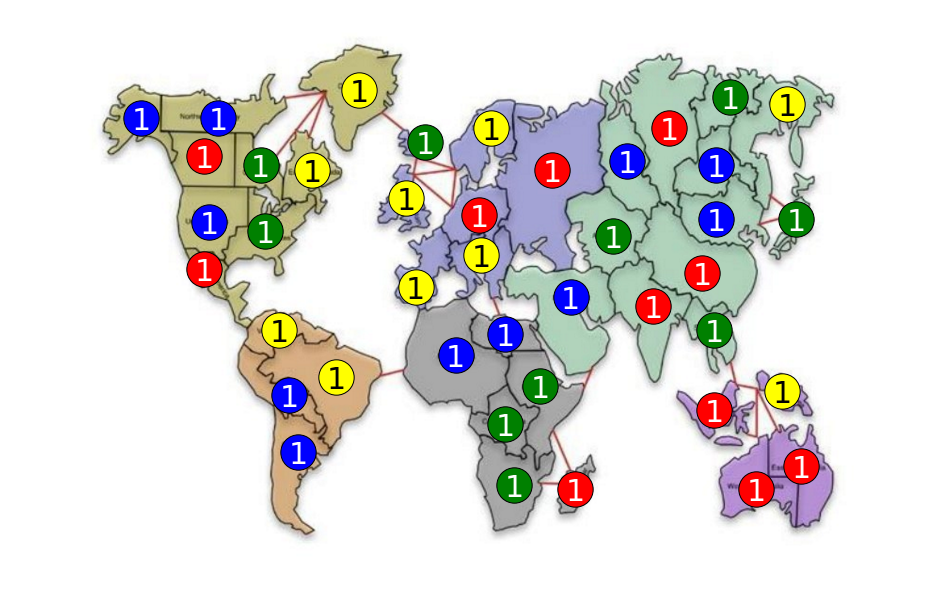

In [4]:
b.plot_board()

We can easily manipulate the armies on the board:

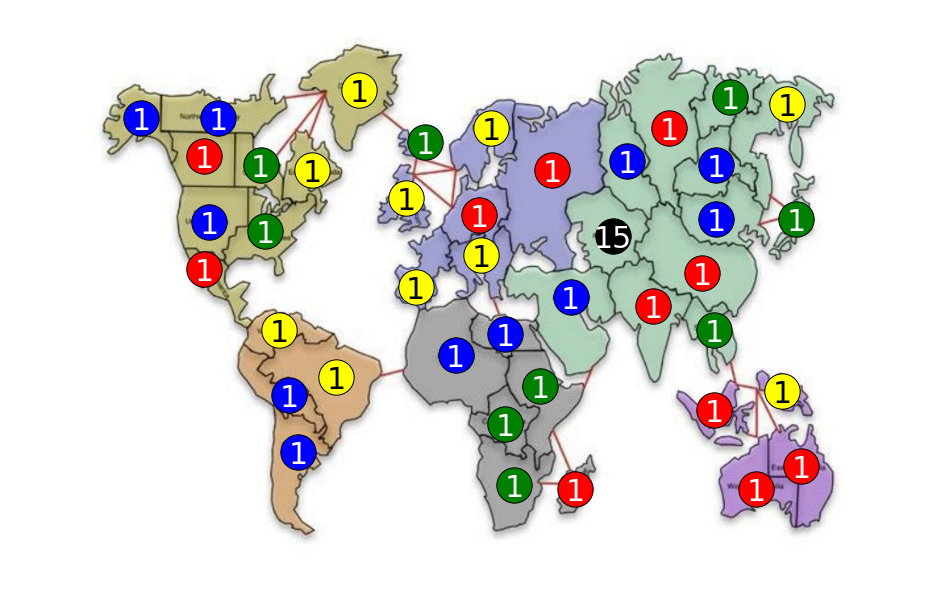

In [5]:
b.set_owner(territory_id=0, player_id=5)
b.set_armies(territory_id=0, n=15)
b.plot_board()

The board is aware of the layout of the territories:

In [6]:
for territory_id, player_id, armies in b.neighbors(territory_id=0):
    print 'Territory', territory_id, 'owned by player', player_id, 'is occupied by', armies, 'armies'

Territory 6 owned by player 0 is occupied by 1 armies
Territory 15 owned by player 0 is occupied by 1 armies
Territory 21 owned by player 1 is occupied by 1 armies
Territory 35 owned by player 0 is occupied by 1 armies
Territory 36 owned by player 1 is occupied by 1 armies


And can handle attack moves:

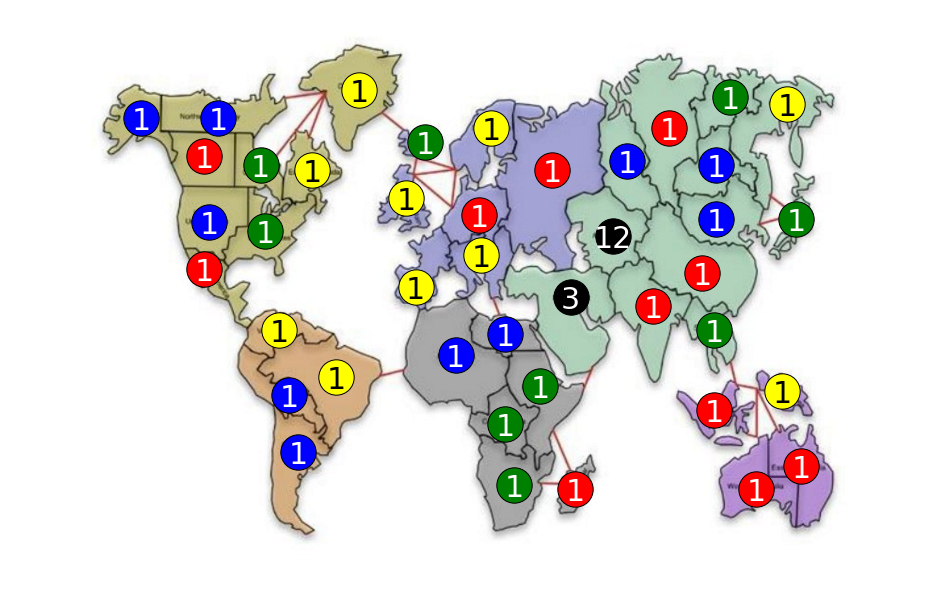

In [7]:
b.attack(from_territory=0, to_territory=21, n_armies=3)
b.plot_board()

### Missions

We can get all available missions using the `missions` function:

In [8]:
from missions import missions
all_missions = missions(n_players=4)

for m in all_missions:
    print m.description

conquer asia and south-america
conquer africa and asia
conquer africa and north-america
conquer north-america and oceania
conquer europe and south-america and an additional continent of choice
conquer europe and oceania and an additional continent of choice
conquer at least 24 territories
conquer at least 18 territories and have at least 2 armies on each territory
eliminate the red player
eliminate the blue player
eliminate the green player
eliminate the yellow player


Each mission is aware of the player it is assigned to:

In [9]:
mission = all_missions[0]
mission

Mission("conquer asia and south-america", unassigned)

In [10]:
mission.assign_to(player_id=0)
mission

Mission("conquer asia and south-america", assigned to red)

...and can evaluate whether the mission has been achieved yet:

In [11]:
mission.evaluate(board=b)

False

There is a special case when a player's mission is to kill himself:

In [12]:
mission = all_missions[-1]
mission

Mission("eliminate the yellow player", unassigned)

In [13]:
mission.assign_to(player_id=3)
mission

Mission("fallback: conquer at least 24 territories", assigned to yellow)

### Players

A player object is required to have four methods:

- `reinforce()`, 
- `attack()`,
- `fortify()`,
- `turn_in_cards()`

## Playing a game

Let's go through a whole game. 

We'll use four `RandomPlayer`s, which take a random decision at every step of their turn.


In [14]:
random.seed(42)

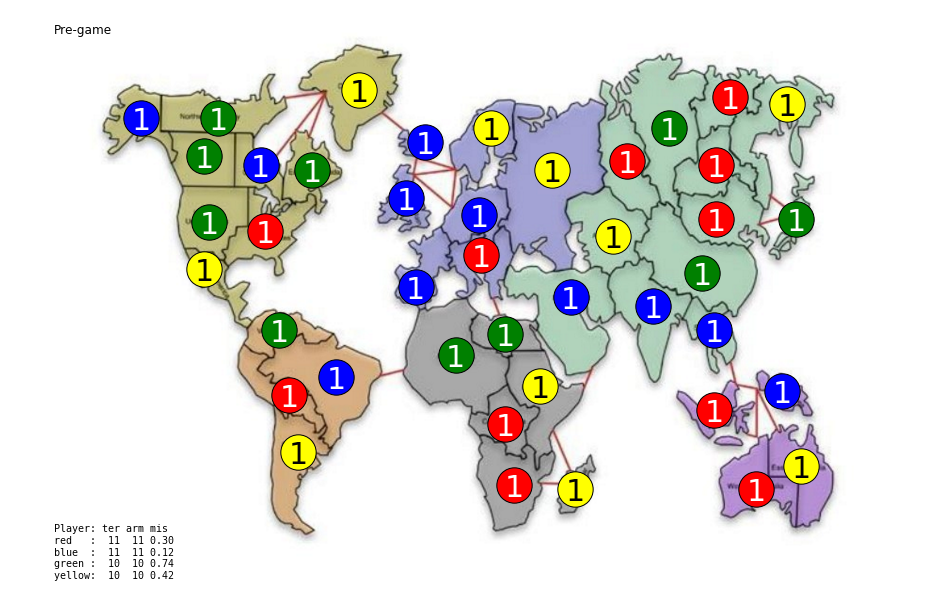

In [35]:
import game, player
risk_game = game.Game.create([player.RandomPlayer() for i in range(4)])
risk_game.plot()

Now the players may place armies until they each have 30 armies:

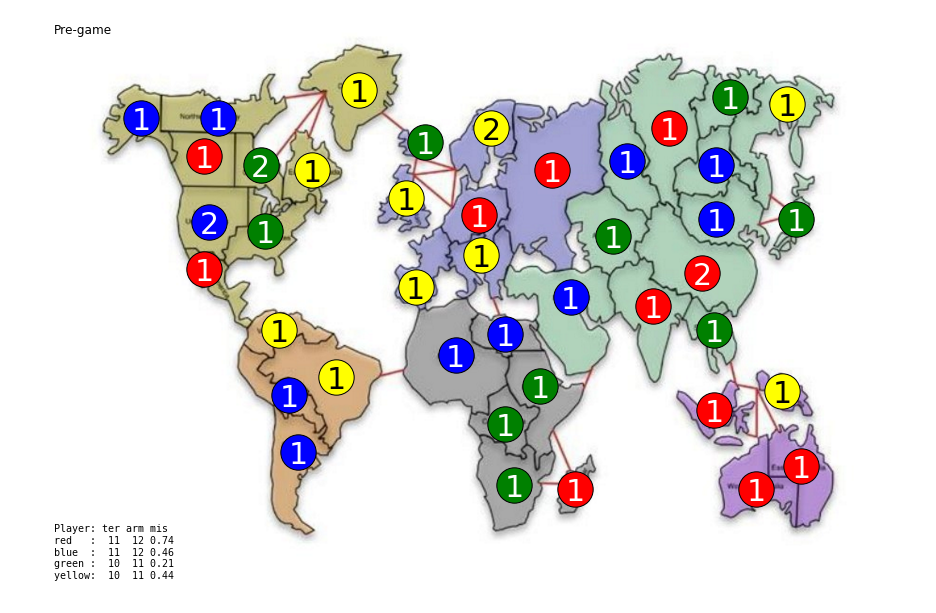

In [16]:
risk_game.initialize_single_army()
risk_game.plot()

Calling `initialize_armies()` will have them place _all_ armies:

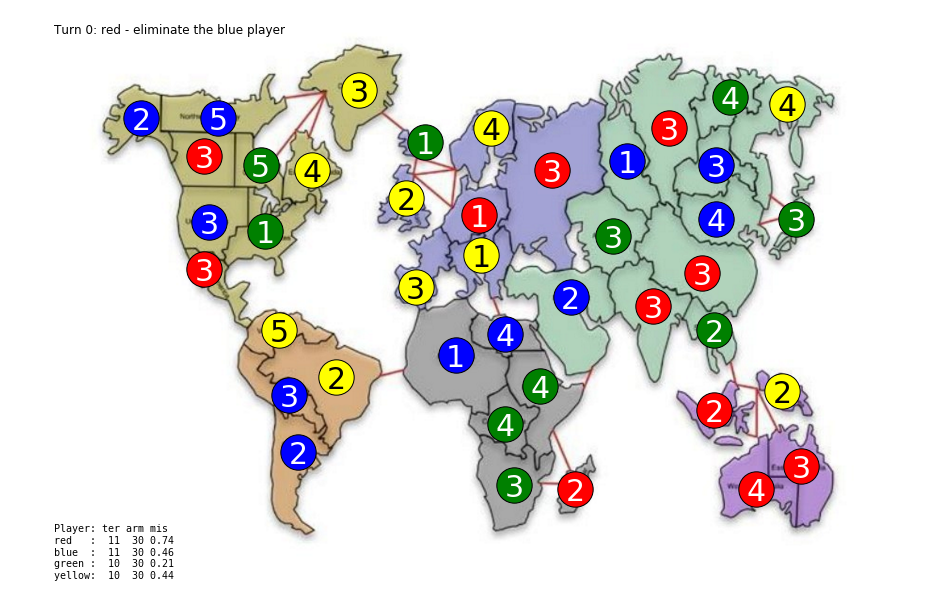

In [17]:
risk_game.initialize_armies()
risk_game.plot()

Now the first player may play his turn.

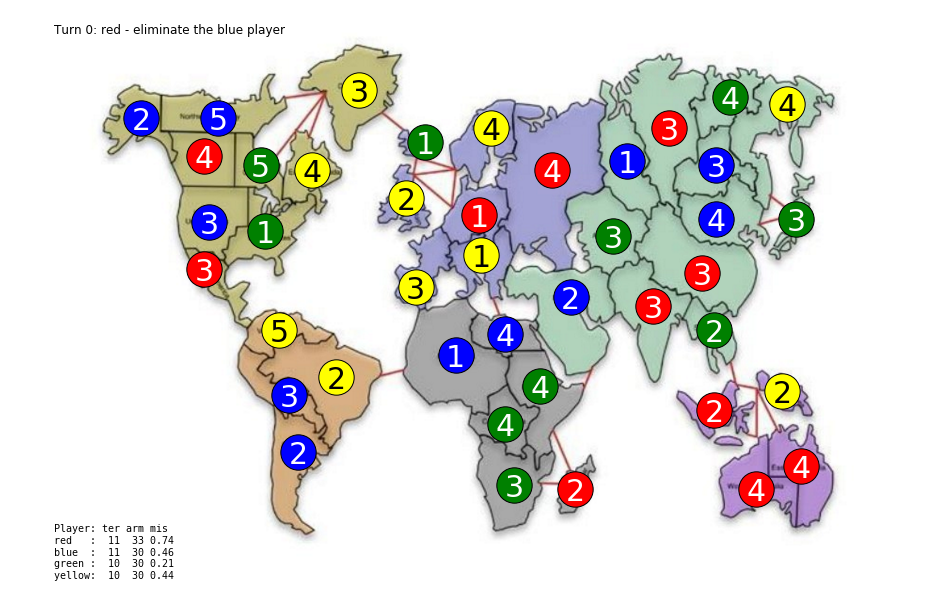

In [18]:
risk_game.reinforce(risk_game.current_player)
risk_game.plot()

Then the attack phase:

In [19]:
risk_game.attack(risk_game.current_player)

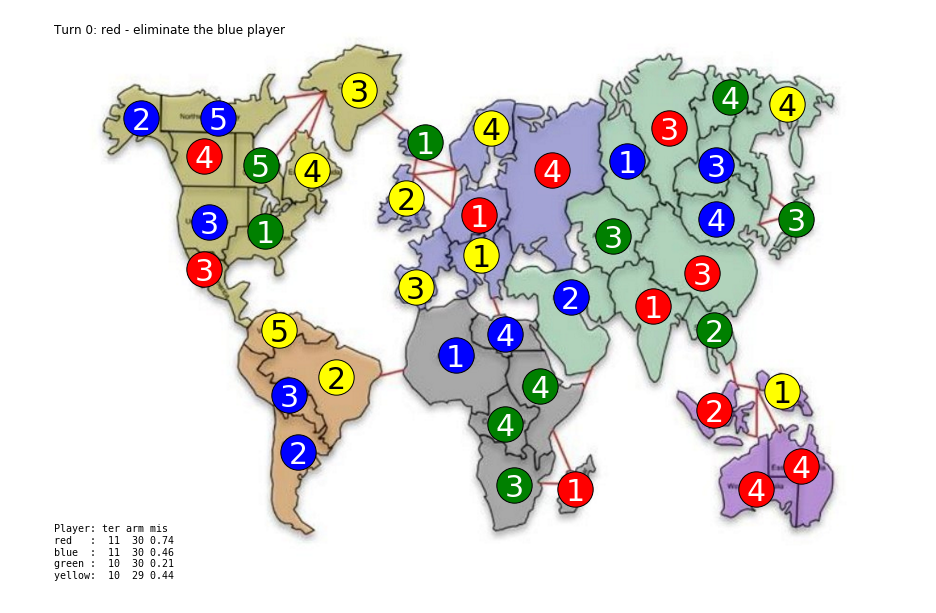

In [20]:
risk_game.attack(risk_game.current_player)
risk_game.plot()

And finally the fortification phase:

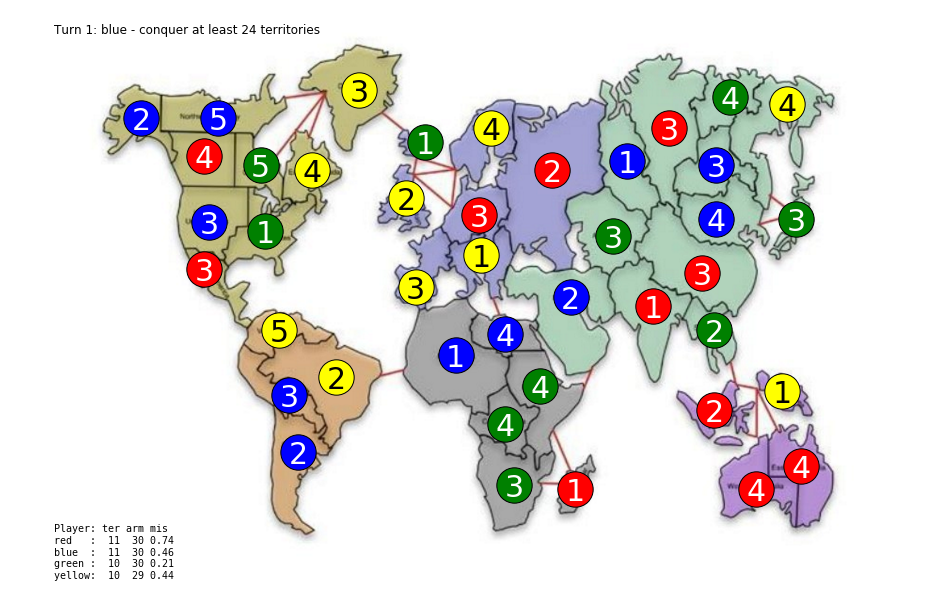

In [21]:
risk_game.fortify(risk_game.current_player)
risk_game.next_turn()
risk_game.plot()

We can do this more quickly by using the `play_turn()` method:

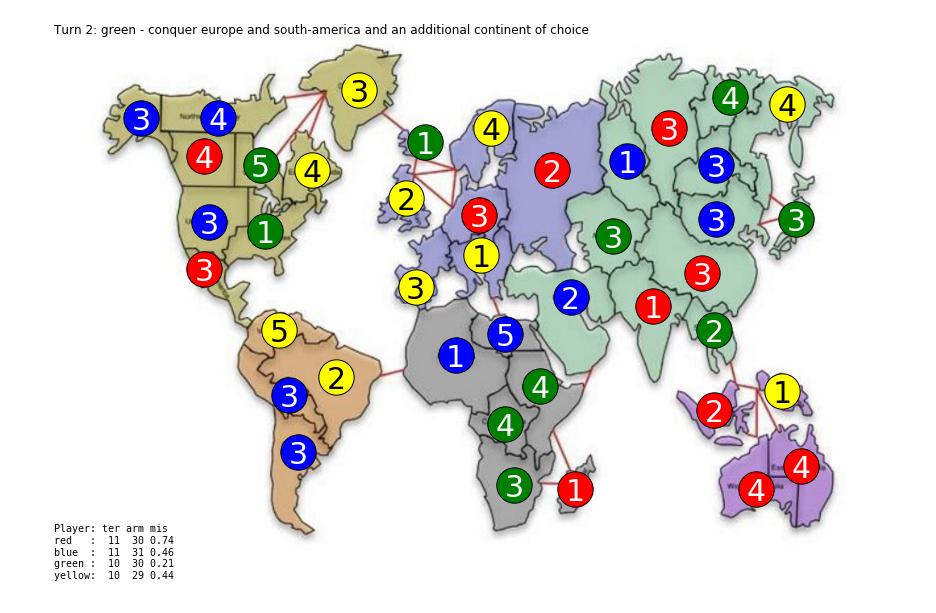

In [22]:
risk_game.play_turn()
risk_game.plot()

Now let's fast-forward 10 turns:

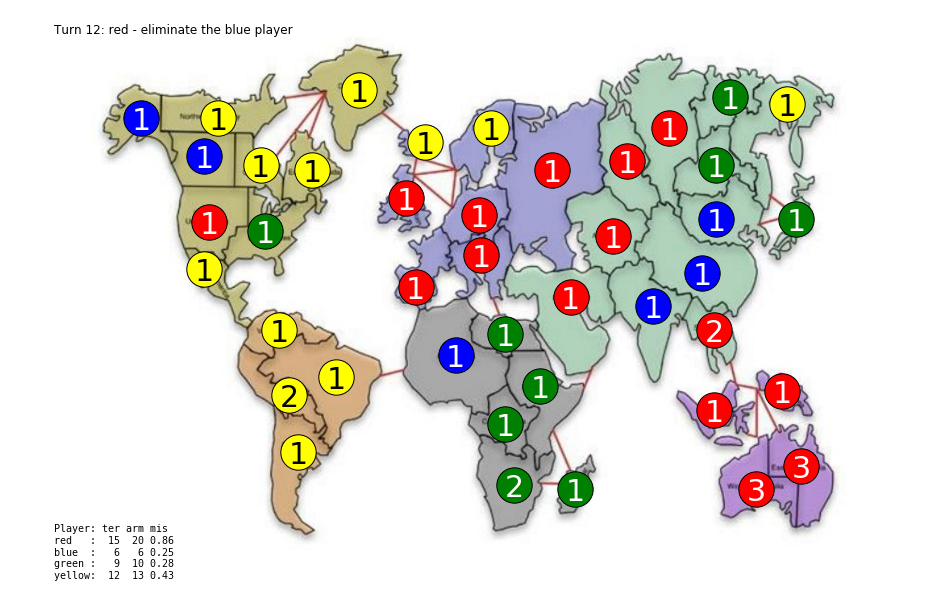

In [23]:
for i in range(10): 
    risk_game.play_turn()
risk_game.plot()

And to the end of the game:

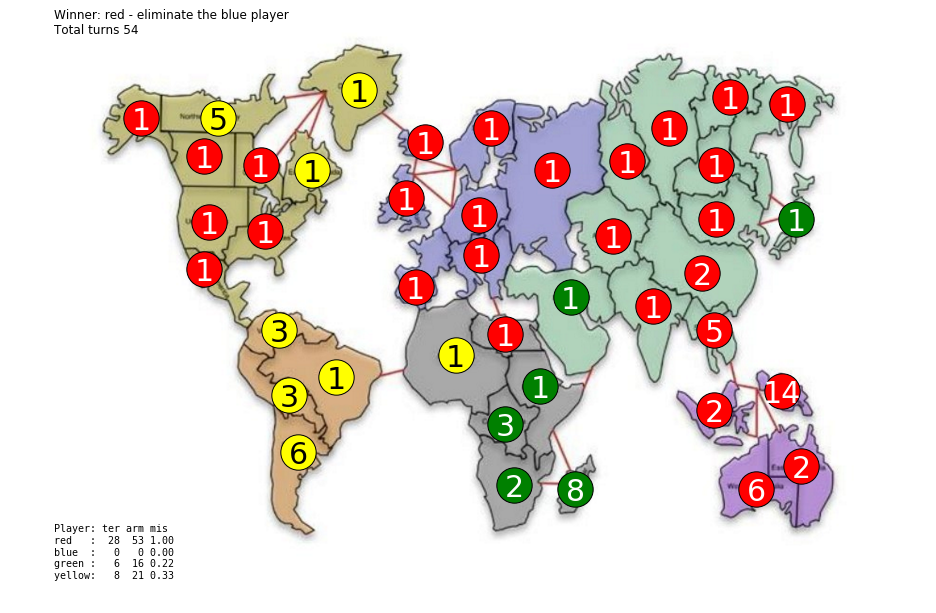

In [24]:
while not risk_game.has_ended(): 
    risk_game.play_turn()
risk_game.plot()

# Genetic Algorithms

## What is a _GA_?

A machine learning algorithm based on evolution and natural selection.

## Why a _GA_?

Easy to use with little knowledge of the problem.

Robust against:
- noise
- many dimensions

## A simple example

Imagine we are trying to solve a puzzle.   
The solution of the puzzle is a string of 16 bits,    
e.g. `0110 0010 1101 0001`.    

We can evaluate a candidate solution using a function
that returns the number of correct bits.     
For example
`0110 1101 1000 1010` would yield `7`.



In [25]:
import random
def random_solution():
    return ' '.join([
        ''.join(['0' if random.random() < 0.5 else '1' for i in range(4)])
        for i in range(4)
    ])
def compare_solution(y):
    x = '0110 0010 1101 0001'
    return sum((
        1 if u == v and u != ' ' else 0
        for u, v in zip(x, y)
    ))

In [26]:
for i in range(6):
    rs = random_solution()
    print rs, compare_solution(rs)

1111 1000 1110 1001 9
1101 1101 0101 1010 5
0101 1101 0010 0101 5
1001 0001 1000 0101 7
1011 1001 0101 1100 6
1111 0101 0101 1100 7


We can randomly generate a few solutions:

- `1110 1010 0010 0101` $\rightarrow$ 9
- `0101 1100 1001 0011` $\rightarrow$ 9
- `1101 1111 0111 1111` $\rightarrow$ 5
- `0110 0101 0010 1010` $\rightarrow$ 6

To get further we can _combine_ the best solutions (the _parents_), 

- <font face='Courier', color='red'>1110 1010 0010 0101</font> $\rightarrow$ 9
- <font face='Courier', color='blue'>0101 1100 1001 0011</font> $\rightarrow$ 9

by splitting them up and pasting them together to form _children_,

- <font face='Courier', color='blue'>0101 1100</font> <font face='Courier', color='red'>0010 0101</font> $\rightarrow$ 6
- <font face='Courier', color='red'>1110 1010</font> <font face='Courier', color='blue'>1001 0011</font> $\rightarrow$ 12

Another way to improve a solution is to randomly _mutate_ one (or more) bits:

- `1110 1010 1001 0011` $\rightarrow$ 12

to

- `1`__<font face='Courier', color='red'>0</font>__`10 1010 1001 0011` $\rightarrow$ 11
- `1110 1010 1`__<font face='Courier', color='red'>1</font>__`01 0011` $\rightarrow$ 13
- `1110 1010 1001 0`__<font face='Courier', color='red'>1</font>__`11` $\rightarrow$ 11
- `1110 1010 1001 00`__<font face='Courier', color='red'>0</font>__`1` $\rightarrow$ 13


We can keep _combining_ and _mutating_ until we have found a satisfactory solution.

### A _GA_ in short

- A (random) initial pool of solutions
- An evaluation function
- A combine method
- A mutate method

# A _GA_ for Risk

### Evaluating a Risk player

- <font face='Courier', color='blue'>1110 1010 0010 0101</font> $\rightarrow$ 9
- <font face='Courier', color='blue'>0101 1100 1001 0011</font> $\rightarrow$ 9
- <font face='Courier', color='red'>0101 1100 0010 0101</font> $\rightarrow$ 6
- <font face='Courier', color='green'>1110 1010 1001 0011</font> $\rightarrow$ 12

Suppose we have four risk players, `[p1, p2, p3, p4]`

Which is the best?

We could have them play a game:

`game(p1, p2, p3, p4)` $\rightarrow$ `p3`

And a few more:

`game(p1, p2, p3, p4)` $\rightarrow$ `p1`    
`game(p1, p2, p3, p4)` $\rightarrow$ `p1`    
`game(p1, p2, p3, p4)` $\rightarrow$ `p4`    
`game(p1, p2, p3, p4)` $\rightarrow$ `p1`    
`game(p1, p2, p3, p4)` $\rightarrow$ `p2`    
`game(p1, p2, p3, p4)` $\rightarrow$ `p2`

What if we have 8 players?

`[p1, p2, ..., p7, p8]`

`game(p1, p2, p3, p4)` $\rightarrow$ `p1`  
`game(p5, p6, p7, p8)` $\rightarrow$ `p7`

Is `p1` better than `p5`?

We could play games with all combinations:

`game(p1, p2, p3, p4)`    
`game(p1, p2, p3, p5)`    
...    
`game(p5, p6, p7, p8)`

70

Now what if we have 100 players?

`[p1, p2, ..., p99, p100]`

Playing a single game in every combination would require millions of games.

## Trueskill

> TrueSkill is a Bayesian ranking algorithm developed by Microsoft Research

### The prior: two _new_ players

![trueskill](ts1.1.png)

_source:_ Vincent Warmerdam - [koaning.io](koaning.io)

### Posterior: player 1 wins

![trueskill](ts1.2.png)

### Posterior: player 2 wins

![trueskill](ts1.3.png)

### Prior: player 1 is _very_ good. Player 2 is new

![trueskill](ts2.1.png)

### Posterior: player 1 wins

![trueskill](ts2.1.png)

### Posterior: player 2 wins

![trueskill](ts2.3.png)

An implementation is readily available:

`> pip install trueskill`

In [27]:
import trueskill

### Using Trueskill

Every new player gets a default score of 25:

In [28]:
a = trueskill.Rating()
b = trueskill.Rating()
print a
print b

trueskill.Rating(mu=25.000, sigma=8.333)
trueskill.Rating(mu=25.000, sigma=8.333)


After a game we can calculate the new ratings:

In [29]:
print 'Before:', [(a, ), (b, )]
print 'After: ', trueskill.rate(rating_groups=[[a], [b]], ranks=[1, 2])

Before: [(trueskill.Rating(mu=25.000, sigma=8.333),), (trueskill.Rating(mu=25.000, sigma=8.333),)]
After:  [(trueskill.Rating(mu=29.396, sigma=7.171),), (trueskill.Rating(mu=20.604, sigma=7.171),)]


In [30]:
(a, ), (b, ) = trueskill.rate(rating_groups=[[a], [b]], ranks=[1, 2])

In [31]:
print 'Before:', [(a, ), (b, )]
print 'A wins:', trueskill.rate(rating_groups=[[a], [b]], ranks=[1, 2])


Before: [(trueskill.Rating(mu=29.396, sigma=7.171),), (trueskill.Rating(mu=20.604, sigma=7.171),)]
A wins: [(trueskill.Rating(mu=31.230, sigma=6.523),), (trueskill.Rating(mu=18.770, sigma=6.523),)]


In [32]:
print 'B wins:', trueskill.rate(rating_groups=[[a], [b]], ranks=[2, 1])

B wins: [(trueskill.Rating(mu=23.357, sigma=6.040),), (trueskill.Rating(mu=26.643, sigma=6.040),)]


Trueskill also handles multiple players in a tie:

In [33]:
a = trueskill.Rating()
b = trueskill.Rating()
c = trueskill.Rating()
d = trueskill.Rating()

In [34]:
trueskill.rate(rating_groups=[[a], [b, c, d]], ranks=[1, 2])

[(trueskill.Rating(mu=36.337, sigma=7.528),),
 (trueskill.Rating(mu=13.663, sigma=7.528),
  trueskill.Rating(mu=13.663, sigma=7.528),
  trueskill.Rating(mu=13.663, sigma=7.528))]

## A Genetic Risk player

As said before, a player needs to implement:

- `reinforce()`, 
- `attack()`,
- `fortify()`,
- `turn_in_cards()`

### How to pick a move?

1. Create a list of all possible moves.
2. Rank the moves based on predefined criteria.
3. Pick the top-ranked move.

### An example: _Placing a reinforcement._

Let's define:
- $\text{territory ratio} \equiv (n_{hostile}) / (n_{hostile} + n_{own})$
- $\text{mission}$: relevance of territory for mission
- ...

$$\begin{array}{ccc}
\textbf{territory} & \text{territory_ratio} & \text{mission} \\
10 & 0.0 & 1 \\
18 & 0.6 & 1 \\
24 & 0.0 & 1 \\
33 & 0.5 & 0 \\
40 & 0.3 & 0 \\
42 & 0.2 & 1 \end{array}$$

### Define a _reinforcement rank_

$$
\begin{align}
\text{reinforcement rank} &\equiv \text{territory_ratio} \cdot w_\text{territory_ratio} + \text{mission} \cdot w_\text{mission}.
\end{align}
$$



Let's say $w_\text{territory_ratio} = 1$ and $w_\text{mission} = 2$, then

$$\begin{array}{ccc}
\textbf{territory} & \text{territory_ratio} & \text{mission} & \textbf{rank} \\
10 & 0.0 & 1 & 2.0 \\
18 & 0.6 & 1 & 2.6\\
24 & 0.0 & 1 & 2.0\\
33 & 0.5 & 0 & 0.5 \\
40 & 0.3 & 0 & 0.3 \\
42 & 0.2 & 1 & 2.2 \end{array}$$

So we pick territory 18.

### How to pick the weights?

__Using a GA!__

- Initialize players with random weights.
- Play many games
- Drop the bad players 
- Combine and mutate to create new players
- Repeat

### Territory ratio

![territory vantage](tvantage_wgt.png)

So why ~15? What is it normalized to?

### Mission weight

![mission weight](re_mission_wgt.png)

__Conclusion:__ territory ratio is ~15 times more important than the mission!

### All reinforcement factors

1. _Direct bonus_: bonus reinforcements from a complete continent.
2. _Indirect bonus_: fraction of continent owned $\times$ bonus reinforcements.
3. _Mission_: value for mission (depends on mission).
4. _Army vantage_: hostile armies / (hostile armies + own armies).
5. _Territory vantage_: hostile neighbors / total neighbors.

### Army vantage

![army vantage](avantage_wgt.png)

### Direct bonus

![direct bonus](dbonus_wgt.png)

### All weights

![all_weights](all_weights.png)

## So... are we done?

# <center>No</center>

![all_weights](all_weights.png)

### Also:

- We only allow linear combinations

- Players do not look ahead

- Players do not adapt to opponents

## Conclusion

- Play Risk in python

- Genetic representation of a Risk player

- Used a genetic algorithm to find better players    

Watch our blog: [blog.godatadriven.com](https://blog.godatadriven.com)    